# Spatial Transformer networks

https://arxiv.org/pdf/1506.02025.pdf


In [1]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets
from matplotlib import pyplot as plt
from scipy.io.matlab import loadmat
import tensorflow as tf
import numpy as np
import datetime
import os
import tensorflow_addons as tfa
import cv2 as cv
import math

%load_ext tensorboard

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
tf.random.set_seed(9)

In [3]:
batch_size = 256
epochs = 3

In [4]:
(X_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
X_train, x_test = (X_train / 255.0).astype(np.float32), x_test.astype(np.float32) / 255.0

# Build Localization & Bilinear layer for the spatial transformer

In [5]:
class Localization(tf.keras.layers.Layer):
    def __init__(self):
        super(Localization, self).__init__()
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.conv1 = tf.keras.layers.Conv2D(20, [5, 5], activation='relu')
        self.pool2 = tf.keras.layers.MaxPool2D()
        self.conv2 = tf.keras.layers.Conv2D(20, [5, 5], activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(20, activation='relu')
        self.fc2 = tf.keras.layers.Dense(6, activation=None, bias_initializer=tf.keras.initializers.constant([1.0, 0.0, 0.0, 0.0, 1.0, 0.0]), kernel_initializer='zeros')

    def build(self, input_shape):
        print("Building Localization Network with input shape:", input_shape)

    def compute_output_shape(self, input_shape):
        return [None, 6]

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        theta = self.fc2(x)
        theta = tf.keras.layers.Reshape((2, 3))(theta)
        return theta

In [6]:
class BilinearInterpolation(tf.keras.layers.Layer):
    def __init__(self, height=40, width=40):
        super(BilinearInterpolation, self).__init__()
        self.height = height
        self.width = width

    def compute_output_shape(self, input_shape):
        return [None, self.height, self.width, 1]

    def get_config(self):
        return {
            'height': self.height,
            'width': self.width,
        }
    
    def build(self, input_shape):
        print("Building Bilinear Interpolation Layer with input shape:", input_shape)

    def advance_indexing(self, inputs, x, y):
        '''
        Numpy like advance indexing is not supported in tensorflow, hence, this function is a hack around the same method
        '''        
        shape = tf.shape(inputs)
        batch_size, _, _ = shape[0], shape[1], shape[2]
        
        batch_idx = tf.range(0, batch_size)
        batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1))
        b = tf.tile(batch_idx, (1, self.height, self.width))
        indices = tf.stack([b, y, x], 3)
        return tf.gather_nd(inputs, indices)

    def call(self, inputs):
        images, theta = inputs
        homogenous_coordinates = self.grid_generator(batch=tf.shape(images)[0])
        return self.interpolate(images, homogenous_coordinates, theta)

    def grid_generator(self, batch):
        x = tf.linspace(-1, 1, self.width)
        y = tf.linspace(-1, 1, self.height)
            
        xx, yy = tf.meshgrid(x, y)
        xx = tf.reshape(xx, (-1,))
        yy = tf.reshape(yy, (-1,))
        homogenous_coordinates = tf.stack([xx, yy, tf.ones_like(xx)])
        homogenous_coordinates = tf.expand_dims(homogenous_coordinates, axis=0)
        homogenous_coordinates = tf.tile(homogenous_coordinates, [batch, 1, 1])
        homogenous_coordinates = tf.cast(homogenous_coordinates, dtype=tf.float32)
        return homogenous_coordinates
    
    def interpolate(self, images, homogenous_coordinates, theta):

        with tf.name_scope("Transformation"):
            transformed = tf.matmul(theta, homogenous_coordinates)
            transformed = tf.transpose(transformed, perm=[0, 2, 1])
            transformed = tf.reshape(transformed, [-1, self.height, self.width, 2])
                
            x_transformed = transformed[:, :, :, 0]
            y_transformed = transformed[:, :, :, 1]
                
            x = ((x_transformed + 1.) * tf.cast(self.width, dtype=tf.float32)) * 0.5
            y = ((y_transformed + 1.) * tf.cast(self.height, dtype=tf.float32)) * 0.5

        with tf.name_scope("VariableCasting"):
            x0 = tf.cast(tf.math.floor(x), dtype=tf.int32)
            x1 = x0 + 1
            y0 = tf.cast(tf.math.floor(y), dtype=tf.int32)
            y1 = y0 + 1

            x0 = tf.clip_by_value(x0, 0, self.width-1)
            x1 = tf.clip_by_value(x1, 0, self.width-1)
            y0 = tf.clip_by_value(y0, 0, self.height-1)
            y1 = tf.clip_by_value(y1, 0, self.height-1)
            x = tf.clip_by_value(x, 0, tf.cast(self.width, dtype=tf.float32)-1.0)
            y = tf.clip_by_value(y, 0, tf.cast(self.height, dtype=tf.float32)-1)

        with tf.name_scope("AdvanceIndexing"):
            Ia = self.advance_indexing(images, x0, y0)
            Ib = self.advance_indexing(images, x0, y1)
            Ic = self.advance_indexing(images, x1, y0)
            Id = self.advance_indexing(images, x1, y1)

        with tf.name_scope("Interpolation"):
            x0 = tf.cast(x0, dtype=tf.float32)
            x1 = tf.cast(x1, dtype=tf.float32)
            y0 = tf.cast(y0, dtype=tf.float32)
            y1 = tf.cast(y1, dtype=tf.float32)
                            
            wa = (x1-x) * (y1-y)
            wb = (x1-x) * (y-y0)
            wc = (x-x0) * (y1-y)
            wd = (x-x0) * (y-y0)

            wa = tf.expand_dims(wa, axis=3)
            wb = tf.expand_dims(wb, axis=3)
            wc = tf.expand_dims(wc, axis=3)
            wd = tf.expand_dims(wd, axis=3)
                        
        return tf.math.add_n([wa*Ia + wb*Ib + wc*Ic + wd*Id])

# Build the model

In [7]:
def get_model(input_shape):
    image = tf.keras.layers.Input(shape=input_shape)
    theta = Localization()(image)
    x = BilinearInterpolation(height=input_shape[0], width=input_shape[1])([image, theta])
    #x = Polar(pixels=5, size=input_shape[0])(x)
    x = tf.keras.layers.Conv2D(64, [9, 9], activation='relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(64, [7, 7], activation='relu')(x)
    x = tf.keras.layers.GlobalMaxPooling2D()(x)
    #x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(10, activation='softmax')(x)

    return tf.keras.models.Model(inputs=image, outputs=x)

In [8]:
model = get_model((28, 28, 1))

Building Localization Network with input shape: (None, 28, 28, 1)
Building Bilinear Interpolation Layer with input shape: [TensorShape([None, 28, 28, 1]), TensorShape([None, 2, 3])]


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
localization (Localization)     (None, 2, 3)         17086       input_1[0][0]                    
__________________________________________________________________________________________________
bilinear_interpolation (Bilinea (None, 28, 28, 1)    0           input_1[0][0]                    
                                                                 localization[0][0]               
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 20, 20, 64)   5248        bilinear_interpolation[0][0] 

In [10]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [11]:
def schedular(epoch, lr):
    if epoch % 20 == 0 and epoch > 0:
        print("Learning Rate Updated")
        lr /= 10
    return lr

In [12]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(schedular)

# Train the model for 3 epochs on NON-rotated data

In [13]:
history = model.fit(X_train, y_train, epochs=epochs, callbacks=[tensorboard_callback, learning_rate_callback])

Epoch 1/3
1875/1875 [==============================] - 50s 26ms/step - loss: 0.3688 - accuracy: 0.88170s - loss: 0.3
Epoch 2/3
1875/1875 [==============================] - 49s 26ms/step - loss: 0.0477 - accuracy: 0.9854
Epoch 3/3
1875/1875 [==============================] - 45s 24ms/step - loss: 0.0348 - accuracy: 0.9887


In [14]:
model.save_weights('./model/weights', save_format='tf')

# Test the model on NON-rotated data

In [15]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.0269 - accuracy: 0.9916


[0.026948772370815277, 0.991599977016449]

# Test the model on rotated data

In [16]:
x_test_r = [tfa.image.rotate(x, np.random.uniform(-np.pi/2., np.pi/2.)).numpy() for x in x_test]
x_test_r = np.array(x_test_r)[...,None]

In [17]:
model.evaluate(x_test_r, y_test, verbose=1)

313/313 [==============================] - 2s 6ms/step - loss: 2.0332 - accuracy: 0.5897


[2.033159017562866, 0.5896999835968018]

In [18]:
stn = tf.keras.models.Model(inputs=model.inputs, outputs=[model.layers[1].output, model.layers[2].output])

In [19]:
theta, prediction = stn.predict(x_test_r)

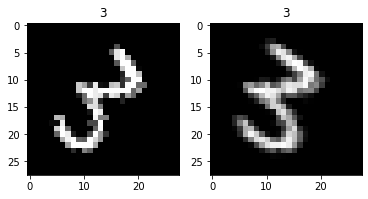

In [24]:
index = 1215
plt.subplot(1,2,1)
plt.title(y_test[index])
plt.imshow(x_test_r[index, :, :], cmap='gray')


plt.subplot(1, 2, 2)
plt.title(np.argmax(model.predict(np.expand_dims(x_test_r[index, :, :], axis=0))))
plt.imshow(prediction[index, :, :, 0], cmap='gray')